**Importing Dependencies**

In [1]:
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import pygame
import pygame.gfxdraw

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

from collections import deque

# Import stable baselines
# Probably not needed
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

**Building the environment**

In [69]:
class SS_Mngmt_Env(Env):

    metadata = {"render_modes": ["human"], "render_fps": 4}
    
    # Define the action and observation space
    def __init__(self, render_mode = None):

        self.I0 = 30 # Initial stock level
        self.stockout_cost = 100 # Cost of stockout
        self.expected_demand = 6 # Expected demand for production

        # Order delay and queue
        self.order_delay = 3
        self.order_queue = deque(maxlen = self.order_delay)

        # To implement
        # self.order_cost = 10 # Cost of ordering stock
        # self.holding_cost = 1 # Cost of holding stock
        # unit cost
        # storage capacities
        # campaign size
        
        # Define action space
        # Change the action space for different campaign sizes
        self.action_space = Discrete(10)
        
        # Define observation space (Stock level) --> to add expected demand, etc.
        self.observation_space = Box(low = np.array([0]), 
                                     high = np.array([100]),
                                     dtype = np.int64)

        # Define the initial state
        self.state = np.array(self.I0)

        # Length of the episode
        self.episode_length = 29

        # History
        self.stock_history = []
        self.demand_history = []
        self.order_history = []

        # Empty dataframe for plotting the history
        self.history = pd.DataFrame(columns = ['Stock Level', 'Order', 'Demand'])

        self.render_mode = render_mode
        self.screen_initialized = False


    # Defining the step function
    def step(self, action):
        # Returns the next state, reward and whether the episode is done

        # Initialize the reward
        reward = 0

        # Demand for production --> random for now
        self.demand = self.expected_demand + random.randint(-3, 3)

        # Subtract the demand from the stock
        self.state = self.state - self.demand

        # To Do: Implement the cost of ordering stock
        # To Do: Campaign Size

        # If there are enough steps passed since the order was placed, add the order to the stock
        if len(self.order_queue) == self.order_delay:
            self.state += self.order_queue.popleft()

        # Check if the stock level is negative
        if self.state < 0:
            # If the stock level is negative, the cost is the stockout cost
            reward = -self.stockout_cost

        # Calculate the cost of the stock
        # Reward is negative since we want to minimize the cost
        reward = float(reward -(self.state))

        # Check if the episode is done
        done = self.episode_length == 0

        # Decrease the episode length
        self.episode_length -= 1

        obs = np.array([self.state])

        # Append the state to the history
        self.stock_history.append(self.state)
        self.order_history.append(action)
        self.demand_history.append(self.demand)

        # Add the order to the queue
        self.order_queue.append(action)

        # Check if episode is done
        if self.episode_length <= 0: 
            done = True
        else:
            done = False

        # Set placeholder for info
        info = {}

        # Check if the episode is truncated
        truncated = False

        return obs, reward, done, truncated, info

    def render(self):
        # Just check episode lenghth and only plot the last one when using matplotlib          
        if self.render_mode is not None:
            if self.render_mode == "human":
                self.render_human()
                # self.render_pygame()

    def render_human(self):
        # Render the environment  

        plt.clf()

        # Create a list of timestamps for the order history
        timestamps = np.arange(len(self.order_history))

        bar_width = 0.35
        
        plt.plot(self.stock_history, color = 'blue', label = 'Stock Level')
        plt.bar(timestamps - bar_width/2, self.order_history, bar_width, color='red', label='Order')
        plt.bar(timestamps + bar_width/2, self.demand_history, bar_width, color='green', alpha=0.5, label='Demand')
        plt.ylabel('Stock Level')
        plt.xticks(np.arange(0, 30, step=5))
        plt.yticks(np.arange(0, 100, step=10))
        plt.xlabel('Time')
        
        # plt.legend(['Stock Level', 'Order', 'Demand'])

        # Show the plot if the episode is done
        if self.episode_length <= 0:
            plt.show()
        
        return
    
    # Render the environment using Pygame --> Dynamic Rendering
    def render_pygame(self):

        if not self.screen_initialized:
            # Initialize Pygame only once
            pygame.init()
            self.width, self.height = 800, 600
            self.screen = pygame.display.set_mode((self.width, self.height))
            self.font = pygame.font.SysFont('Arial', 18)
            self.screen_initialized = True

        # Clear the screen
        self.screen.fill((255, 255, 255))

        # Draw axes
        pygame.draw.line(self.screen, (0, 0, 0), (50, self.height - 50), (self.width - 50, self.height - 50))  # x-axis
        pygame.draw.line(self.screen, (0, 0, 0), (50, self.height - 50), (50, 50))  # y-axis

        # Add labels to the axes
        x_label = self.font.render('Iterations', True, (0, 0, 0))
        y_label = self.font.render('Stock Level', True, (0, 0, 0))
        y_label = pygame.transform.rotate(y_label, 90)
        self.screen.blit(x_label, (self.width // 2, self.height - 30))
        self.screen.blit(y_label, (10, self.height // 2))

        # Draw grid lines
        for x in range(100, self.width - 50, 50):
            pygame.draw.line(self.screen, (200, 200, 200), (x, 50), (x, self.height - 50))
        for y in range(100, self.height - 50, 50):
            pygame.draw.line(self.screen, (200, 200, 200), (50, y), (self.width - 50, y))

        # Scale the history to fit the window
        if self.stock_history:
            max_stock = max(self.stock_history) if self.stock_history else 1
            scaled_history = [(i * (self.width - 100) / len(self.stock_history) + 50,
                               self.height - (s * (self.height - 100) / max_stock + 50)) for i, s in enumerate(self.stock_history)]

            # Draw the history
            for i in range(1, len(scaled_history)):
                pygame.draw.line(self.screen, (0, 0, 0), scaled_history[i-1], scaled_history[i], 2)

            # Draw data points
            for point in scaled_history:
                pygame.draw.circle(self.screen, (0, 0, 255), (int(point[0]), int(point[1])), 5)

            # Draw bars for actions
            if self.order_history:
                max_order = max(self.order_history) if self.order_history else 1
                scaled_orders = [(i * (self.width - 100) / len(self.order_history) + 50,
                                self.height - (o * (self.height - 100) / max_order + 50)) for i, o in enumerate(self.order_history)]
                
                for i, order in enumerate(scaled_orders):
                    pygame.draw.rect(self.screen, (255, 0, 0), (int(order[0]), int(order[1]), 10, self.height - 50 - int(order[1])))

        # Update the display
        pygame.display.flip()

        # Pause for a short period to allow the plot to update
        pygame.time.wait(200)

        return

    def close(self):
        pygame.display.quit()
        pygame.quit()

    def reset(self, seed = None):
        # Reset the state of the environment back to an initial state

        super().reset(seed = seed) # Reset the seed
        if seed is not None:
            random.seed(seed)

        # Reset the state
        self.state = 50 + random.randint(-20, 20)

        # Reset the episode length
        self.episode_length = 30

        # Reset the order queue
        self.order_queue.clear()

        # Define the initial state
        self.state = np.array(self.I0)

        obs = np.array([self.state])

        # # Append history to the dataframe
        # self.history['Stock Level'] = self.stock_history
        # self.history['Order'] = self.stock_history
        # self.history['Demand'] = self.demand_history

        # Reset the history
        self.stock_history = []
        self.order_history = []
        self.demand_history = []

        # Placeholder for info
        info = {}

        return obs, info


**Testng the environment**

In [25]:
from stable_baselines3.common.env_checker import check_env

env = SS_Mngmt_Env(render_mode="human")
check_env(env, warn=True)

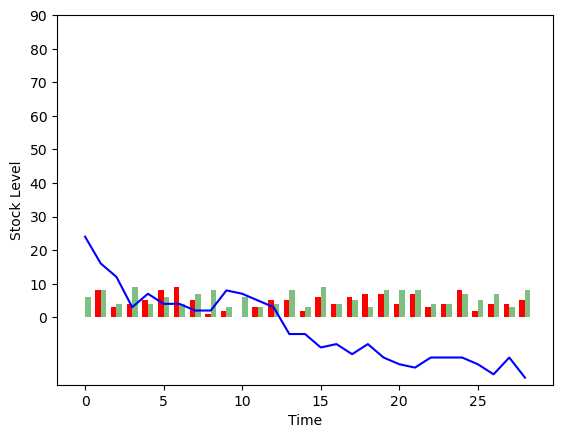

In [72]:
env = SS_Mngmt_Env(render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score+=reward

        # print('Step:{} Score:{} Stock:{} Order:{} Demand:{}'.format(env.episode_length, score, n_state, action, env.demand))

    # print(env.order_history)

In [ ]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score+=reward
    print('Episode:{} Score:{} Stock:{} Last Order:{}'.format(episode, score, n_state, action))

**Train Model**

In [4]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')

In [20]:
env = SS_Mngmt_Env(render_mode="human")

# wrapping the environment in a vectorized environment
env = DummyVecEnv([lambda: env])

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device


In [21]:
model.learn(total_timesteps=100000)

Logging to Training/Logs/PPO_11
-----------------------------
| time/              |      |
|    fps             | 6632 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3935        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013857491 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.29       |
|    explained_variance   | 0.000172    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.72e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 3.85e+05    |
-----------------------------------------
--

In [22]:
model.save(model_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jonasrenfer/miniconda3/envs/rl-course/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


([-767.0,
  -684.0,
  -662.0,
  -468.0,
  -375.0,
  -343.0,
  -571.0,
  -266.0,
  -551.0,
  -607.0],
 [30, 30, 30, 30, 30, 30, 30, 30, 30, 30])

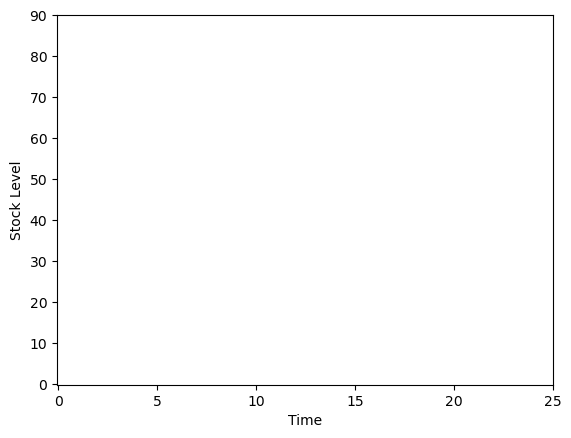

In [70]:
model = PPO.load(model_path, env = env)

env = SS_Mngmt_Env(render_mode="human")

evaluate_policy(model, env, n_eval_episodes=10, render=True, return_episode_rewards=True)

In [24]:
env.close()